# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
    del X_train, y_train
    del X_test, y_test
    print('Clear previously loaded data.')
except:
    pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


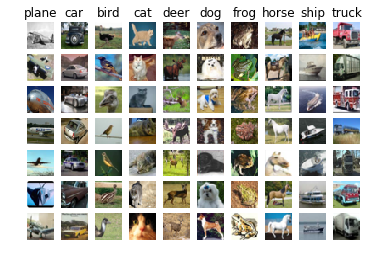

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


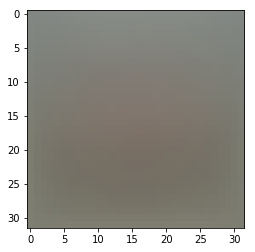

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.869473


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 16.280880 analytic: 16.280880, relative error: 2.411121e-11
numerical: 14.530172 analytic: 14.530172, relative error: 2.117342e-11
numerical: 20.554980 analytic: 20.554980, relative error: 1.658828e-12
numerical: -36.466106 analytic: -36.466106, relative error: 2.771549e-12
numerical: -3.038497 analytic: -3.038497, relative error: 3.412263e-11
numerical: -0.431892 analytic: -0.431892, relative error: 5.820818e-10
numerical: 2.960933 analytic: 2.960933, relative error: 2.695559e-11
numerical: 22.564120 analytic: 22.564120, relative error: 2.251058e-12
numerical: -3.779748 analytic: -3.779748, relative error: 6.008493e-11
numerical: 12.157636 analytic: 12.157636, relative error: 8.269628e-12
numerical: 31.143362 analytic: 31.069063, relative error: 1.194267e-03
numerical: 23.590538 analytic: 23.590538, relative error: 9.817404e-12
numerical: -1.158091 analytic: -1.087503, relative error: 3.143399e-02
numerical: 22.650545 analytic: 22.650545, relative error: 2.245104e-11
numeri

### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

<br>
<br>

## Vectorized loss

In [17]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.869473e+00 computed in 0.055010s
Vectorized loss: 8.869473e+00 computed in 0.002513s
difference: -0.000000


<br>
<br>

## Vectorized loss and gradient

In [39]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized, grad_vectorized_2 = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.058843s
Vectorized loss and gradient: computed in 0.081807s
difference: 0.000000


<br>
<br>

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [48]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 787.538221
iteration 100 / 1500: loss 287.571514
iteration 200 / 1500: loss 107.667509
iteration 300 / 1500: loss 42.351153
iteration 400 / 1500: loss 19.013946
iteration 500 / 1500: loss 10.123955
iteration 600 / 1500: loss 6.625170
iteration 700 / 1500: loss 5.902262
iteration 800 / 1500: loss 5.589764
iteration 900 / 1500: loss 5.093452
iteration 1000 / 1500: loss 5.184767
iteration 1100 / 1500: loss 5.038408
iteration 1200 / 1500: loss 5.252464
iteration 1300 / 1500: loss 5.240084
iteration 1400 / 1500: loss 4.807915
That took 5.827523s


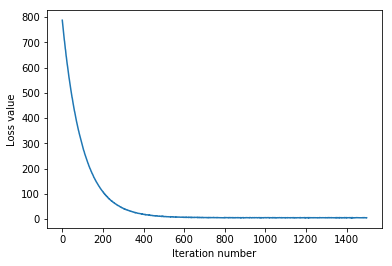

In [49]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [55]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369878
validation accuracy: 0.380000


<br>
<br>

## Tune hyperparameters

In [91]:
from sklearn.metrics import accuracy_score

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-7, 2e-7, 3e-7, 4e-7, 5e-7]
regularization_strengths = [1e3, 2e3, 3e3, 5e3, 1e4]
#(3e-07, 3000.0)

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg_str in regularization_strengths:
        svm = LinearSVM()
        _ = svm.train(X_train, y_train, learning_rate=lr, reg=reg_str, num_iters=1500, verbose=False)
        y_train_pred = svm.predict(X_train)
        y_val_pred = svm.predict(X_val)
        results[(lr, reg_str)] = (accuracy_score(y_train, y_train_pred), 
                                  accuracy_score(y_val, y_val_pred))
        if accuracy_score(y_val, y_val_pred) > best_val:
            best_val = accuracy_score(y_val, y_val_pred)
            best_svm = svm
        
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.314837 val accuracy: 0.314000
lr 1.000000e-07 reg 2.000000e+03 train accuracy: 0.338082 val accuracy: 0.335000
lr 1.000000e-07 reg 3.000000e+03 train accuracy: 0.352633 val accuracy: 0.349000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.370143 val accuracy: 0.361000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.382776 val accuracy: 0.392000
lr 2.000000e-07 reg 1.000000e+03 train accuracy: 0.350510 val accuracy: 0.354000
lr 2.000000e-07 reg 2.000000e+03 train accuracy: 0.377796 val accuracy: 0.367000
lr 2.000000e-07 reg 3.000000e+03 train accuracy: 0.379816 val accuracy: 0.377000
lr 2.000000e-07 reg 5.000000e+03 train accuracy: 0.390714 val accuracy: 0.392000
lr 2.000000e-07 reg 1.000000e+04 train accuracy: 0.372633 val accuracy: 0.372000
lr 3.000000e-07 reg 1.000000e+03 train accuracy: 0.376898 val accuracy: 0.367000
lr 3.000000e-07 reg 2.000000e+03 train accuracy: 0.386347 val accuracy: 0.390000
lr 3.000000e-07 reg 3.000000

<br>
<br>

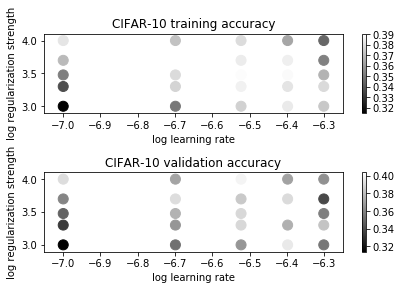

In [93]:
# Visualize the cross-validation results
import math
%matplotlib inline

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.tight_layout()

In [94]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.374000


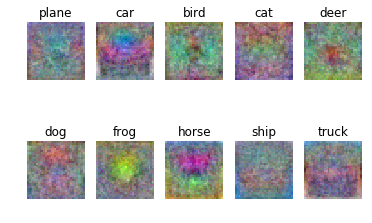

In [95]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*

<br>
<br>

## My notes

In [ ]:
import numpy as np
from random import shuffle

def svm_loss_naive(W, X, y, reg):
    """
    Structured SVM loss function, naive implementation (with loops).

    Inputs have dimension D, there are C classes, and we operate on minibatches of N examples.

    Inputs:
        - W: A numpy array of shape (D, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c means that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

    Returns a tuple of:
        - loss as single float
        - gradient with respect to weights W; an array of same shape as W
    """

    dW = np.zeros(W.shape) # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    
    for i in range(num_train):
        num_scores_above_margin = 0
        scores = X[i].dot(W)
        correct_class_score = scores[y[i]]
        for j in range(num_classes):
            if j == y[i]:
                continue
            margin = scores[j] - correct_class_score + 1 # note delta = 1
            if margin > 0:
                loss += margin
                num_scores_above_margin += 1
                dW[:,j] += X[i]
        dW[:,y[i]] -= num_scores_above_margin*X[i] 
        

  # Right now the loss is a sum over all training examples, but we want it
  # to be an average instead so we divide by num_train.
    loss /= num_train
    dW /= num_train

  # Add regularization to the loss.
    loss += reg * np.sum(W * W)
    dW += 2*reg*W

  #############################################################################
  # TODO:                                                                     #
  # Compute the gradient of the loss function and store it dW.                #
  # Rather that first computing the loss and then computing the derivative,   #
  # it may be simpler to compute the derivative at the same time that the     #
  # loss is being computed. As a result you may need to modify some of the    #
  # code above to compute the gradient.                                       #
  #############################################################################

    
    
    return loss, dW

In [ ]:
def svm_loss_vectorized(W, X, y, reg):
    """
    Structured SVM loss function, vectorized implementation.

    Inputs:
        - W: A numpy array of shape (D, C) containing weights.
        - X: A numpy array of shape (N, D) containing a minibatch of data.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c means that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

    Returns a tuple of:
        - loss as single float
        - gradient with respect to weights W; an array of same shape as W
    
    Inputs have dimension D, there are C classes, and we operate on minibatches of N examples.
    """
    loss = 0.0
    dW = np.zeros(W.shape) # initialize the gradient as zero

  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the structured SVM loss, storing the    #
  # result in loss.                                                           #
  #############################################################################
  #pass
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################
    
    dW = np.zeros(W.shape) # initialize the gradient as zero

    # compute the loss and the gradient
    num_classes = W.shape[1]
    num_train = X.shape[0]
    loss = 0.0
    
    # Matrix of scores with shape (N,D)*(D,C) = (N,C)
    scores=X@W
    
    # Vector of scores for correct label with shape (N, 1) (Using integer array indexing)
    correct_scores = scores[np.arange(num_train),y]
    correct_scores = correct_scores.reshape((-1,1))
    
    # Matrix of score margins with shape (N, C)
    margin = (scores-correct_scores+1) # Sj-Syi+1 (note delta = 1)
    
    # Zero out margin of correct scores (otherwise margin is always 1 for correct score)
    margin[np.arange(num_train), y] = 0
    
    # mask of scores above margin (margin>0) with shape (N,C)
    above_margin_mask=(margin>0).astype(int)
    
    # Loss is the sum of all margins greater than 0, where margin*above_margin_mask is (N,C)
    total_loss = np.sum(margin*above_margin_mask)

    # (subtract N since correct labels result in a 1 margin and is summed N times)
    #loss = (total_loss - num_train)/num_train
    loss = (total_loss)/num_train
    
    # Add Regularization to loss
    loss += reg * np.sum(W * W)
  #############################################################################
  # TODO:                                                                     #
  # Implement a vectorized version of the gradient for the structured SVM     #
  # loss, storing the result in dW.                                           #
  #                                                                           #
  # Hint: Instead of computing the gradient from scratch, it may be easier    #
  # to reuse some of the intermediate values that you used to compute the     #
  # loss.                                                                     #
  #############################################################################
    # Replace mask value for  the correct class with the number of scores above margin
    above_margin_mask[np.arange(len(above_margin_mask)), y] = -np.sum(above_margin_mask, axis=1)
    
    # Align dimensions for broadcasting
    X = X[:,:,None] # shape (N,D,1)
    above_margin_mask = above_margin_mask[:,None,:] # shape (N,1,C)
    
    # Tensor of gradients across all data points with shape (N,D,C)
    # See https://twice22.github.io/hingeloss/ (backward pass section)
    dW_X = X*above_margin_mask
    
    # Sum and average to compute the final gradient 
    dW = (np.sum(dW_X, axis=0))/(len(dW_X))
    
    # Add regularization term
    dW += reg * np.sum(W * W)
  #############################################################################
  #                             END OF YOUR CODE                              #
  #############################################################################

    return loss, dW


In [ ]:
# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

In [15]:
reg = 0.000005

In [16]:
num_classes = W.shape[1]
num_train = X_dev.shape[0]
loss = 0.0
    
# Matrix of scores with shape (N,D)*(D,C) = (N,C)
scores=X_dev@W
# Vector of scores for correct label with shape (N, 1)
correct_scores = scores[np.arange(0,num_train),y_dev]
correct_scores = correct_scores.reshape((-1,1))
    
# Matrix of score margins with shape (N, C)
margin = (scores-correct_scores+1) # Sj-Syi+1 (note delta = 1)

# Zero out margin of correct scores (otherwise margin is always 1 for correct score)
margin[np.arange(num_train), y_dev] = 0

# Boolean mask of scores above margin (margin>0)
above_margin_mask=(margin>0)
    
# Loss is the sum of all margins greater than 0
total_loss = np.sum(margin*above_margin_mask)

# (subtract N since correct labels result in a 1 margin and is summed N times)
loss = (total_loss)/num_train
    
# Add Regularization to loss
loss += reg * np.sum(W * W)

In [17]:
loss

9.103645975199504

In [18]:
above_margin_mask.shape

(500, 10)

<br>
<br>

## Vectorized gradient

In [30]:
X_dev_test.shape

(500, 3073, 1)

In [31]:
above_margin_test.shape

(500, 1, 10)

Broadcast multiply these two arrays for the intended effect.

- For each 1 (True) value in above_margin along the class dimension C, copy it across all feature dimensions D of X_dev.
- For each row of data in X_dev along the feature dimension D, copy it across all class dimensions C of above_margin.

The result: tensor of shape (500, 3073, 10) where

- data row x_i is only present for a class (3rd dimension) if above margin was == 1 (True) for that class
- the same data row x_i is either present or not present along the class dimension C depending on the mask

sum along the data dimension D to get the sum of all gradients for incorrect class labels

<br>
<br>

## Implement Mini-batch GD

In [9]:
X_dev.shape

(500, 3073)

In [18]:
np.random.choice(np.arange(500), size=200)

array([311, 283, 192, 136, 424, 404, 476, 145, 299, 145, 332,  70,  15,
       278,  59, 233, 415,   1, 346, 274, 375,  60, 462, 437, 404, 257,
       161, 167, 385, 186, 111,  26, 467, 216, 413,  23, 405, 393, 311,
       494, 369,  68, 339, 429, 358, 386, 230, 103, 168, 353, 459,  19,
       228, 112, 392, 353, 329, 232, 307, 376,  56, 128, 251, 355, 101,
        64, 108, 403, 156, 407, 477, 296, 427,   9,  83,   2, 422,  43,
       315, 386,  20, 193, 138, 257, 127,  37, 339, 490, 359, 190,  71,
       467, 346, 440, 441,  46, 476, 251, 273, 485, 125, 117, 365,  81,
       154, 358, 313, 332, 348,  39, 323, 247, 368, 136, 276, 416, 127,
       430, 194,  94, 154, 426,  81, 445,  75,  58, 288, 236,  44,  16,
        98, 167,  93, 368,   3, 356, 384, 332, 264, 267, 251, 361, 451,
         9, 484, 251, 356, 258, 404,  19, 309,  33, 233,  18, 431, 182,
       328, 288, 287, 429, 363, 202, 210,  94, 301, 456, 434, 461, 186,
       368, 298, 306, 457, 340, 352, 131, 386, 293, 403, 274, 11

In [20]:
X_dev.T.shape

(3073, 500)

In [50]:
W.shape

(3073, 10)

In [51]:
X_dev.shape

(500, 3073)

In [ ]:
np.argmax()